# **Alzheimer’s Disease Classification-Model Training and Evaluation**

This notebook impliments build, train, evaluate, and compare multiple machine-learning classification models to predict Alzheimer's disease based on patient demographic, lifestyle, clinical, and cognitive features.




**Import Libraries**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score,
    f1_score, 
    roc_auc_score, 
    confusion_matrix, 
    classification_report,
    roc_curve
    )
from sklearn.inspection import permutation_importance

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


print("All libraries imported successfully")

All libraries imported successfully


**Load and Inspect Data**

In [2]:
#load the cleaned dataset 
df = pd.read_csv('eda1_cleaned_dataset.csv')
print(f"Data loaded: {df.shape}")
print(f"Columns: {df.shape[1]}")
print(f"Rows: {df.shape[0]}")
df.head()

Data loaded: (2149, 39)
Columns: 39
Rows: 2149


,BMI,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,...,HeadInjury,Hypertension,MemoryComplaints,BehavioralProblems,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,-0.655225,0.565923,0.492525,-1.253593,1.119918,0.403677,-1.572661,-1.114429,-0.648199,0.779037,...,0,0,0,0,0,0,0,1,0,0
1,-0.114751,-0.954895,0.945093,-1.538442,0.056836,0.140248,1.593119,0.845730,0.650721,0.680297,...,0,0,0,0,0,0,0,0,1,0
2,-1.366428,1.653006,1.023896,-1.088855,1.487380,1.386812,0.668569,0.445615,-1.418585,-0.859222,...,0,0,0,0,0,1,0,1,0,0
3,0.851625,0.376930,1.227995,0.839804,0.760833,-1.542715,-1.360103,0.388780,0.483468,-0.088723,...,0,0,0,1,0,0,0,0,0,0
4,-0.961607,1.461793,0.486696,-1.443293,-0.824566,0.291653,-0.725756,-0.111924,0.617060,-0.143712,...,0,0,0,0,0,0,1,1,0,0


In [3]:
# Check data types and missing values
print("\nData Info:")
print(f"Missing values: {df.isna().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"\nData types:")
print(df.dtypes.value_counts())


Data Info:
Missing values: 0
Duplicate rows: 0

Data types:
float64    23
int64      16
Name: count, dtype: int64


**Prepare Features and Target**

In [4]:
# Split the data into features (X) and target (y)
X = df.drop("Diagnosis", axis=1) 
y = df["Diagnosis"] 

print("Feature and target created:\n")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nNumber of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

Feature and target created:

X shape: (2149, 38)
y shape: (2149,)

Number of features: 38
Number of samples: 2149


In [5]:
# Display feature columns
print("\nFeature Columns:")
print("-"*20)
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")


Feature Columns:
--------------------
 1. BMI
 2. AlcoholConsumption
 3. PhysicalActivity
 4. DietQuality
 5. SleepQuality
 6. CholesterolTotal
 7. CholesterolLDL
 8. CholesterolHDL
 9. CholesterolTriglycerides
10. MMSE
11. FunctionalAssessment
12. ADL
13. SystolicBP
14. DiastolicBP
15. Age
16. Ethnicity_0
17. Ethnicity_1
18. Ethnicity_2
19. Ethnicity_3
20. EducationLevel_0
21. EducationLevel_1
22. EducationLevel_2
23. EducationLevel_3
24. Gender
25. Smoking
26. FamilyHistoryAlzheimers
27. CardiovascularDisease
28. Diabetes
29. Depression
30. HeadInjury
31. Hypertension
32. MemoryComplaints
33. BehavioralProblems
34. Confusion
35. Disorientation
36. PersonalityChanges
37. DifficultyCompletingTasks
38. Forgetfulness



Target Distribution:
--------------------
Diagnosis
0    1389
1     760
Name: count, dtype: int64

Class balance:
Class 0: 1389 (64.63%)
Class 1: 760 (35.37%)


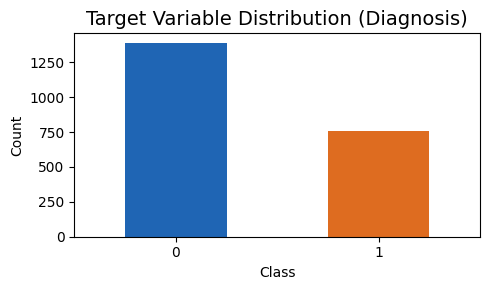

In [6]:
# Check target distribution
print("\nTarget Distribution:")
print("-"*20)
print(y.value_counts())
print(f"\nClass balance:")
print(f"Class 0: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.2f}%)")
print(f"Class 1: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.2f}%)")


# Visualize target distribution
plt.figure(figsize=(5, 3))
y.value_counts().plot(kind='bar', color=["#1f65b4ff", "#dc6210ee"])
plt.title('Target Variable Distribution (Diagnosis)', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### **Train-Test Split**

**Split data into training and testing sets**

In [7]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

print("Data Split Summary:")
print("-"*40)
print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTraining features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())

Data Split Summary:
----------------------------------------
Training set size: 1719 samples (80.0%)
Test set size: 430 samples (20.0%)

Training features shape: (1719, 38)
Test features shape: (430, 38)

Training target distribution:
Diagnosis
0    1111
1     608
Name: count, dtype: int64

Test target distribution:
Diagnosis
0    278
1    152
Name: count, dtype: int64


**Define Machine Learning Models**

In [8]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss"),
    "LightGBM": LGBMClassifier()
}


**Model Training**

In [9]:
model_results = {}

print("Model Performance\n")

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Accuracy metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # Store only test accuracy (optional)
    model_results[name] = test_acc
    
    # Print clean formatted output
    print(f"\n{name}")
    print(f"   Training Accuracy: {train_acc:.4f}")
    print(f"   Testing Accuracy : {test_acc:.4f}")
    print("-" * 30)

    

Model Performance


Logistic Regression
   Training Accuracy: 0.8528
   Testing Accuracy : 0.8163
------------------------------

SVM
   Training Accuracy: 0.9308
   Testing Accuracy : 0.8535
------------------------------

Random Forest
   Training Accuracy: 1.0000
   Testing Accuracy : 0.9442
------------------------------

Gradient Boost
   Training Accuracy: 0.9680
   Testing Accuracy : 0.9465
------------------------------

XGBoost
   Training Accuracy: 1.0000
   Testing Accuracy : 0.9419
------------------------------
[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3290
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

In [10]:
# Evaluate the model
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"\n{name}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")


LightGBM
Training Accuracy: 1.0
Testing Accuracy: 0.9511627906976744


**Confusion Matrices for All Models**

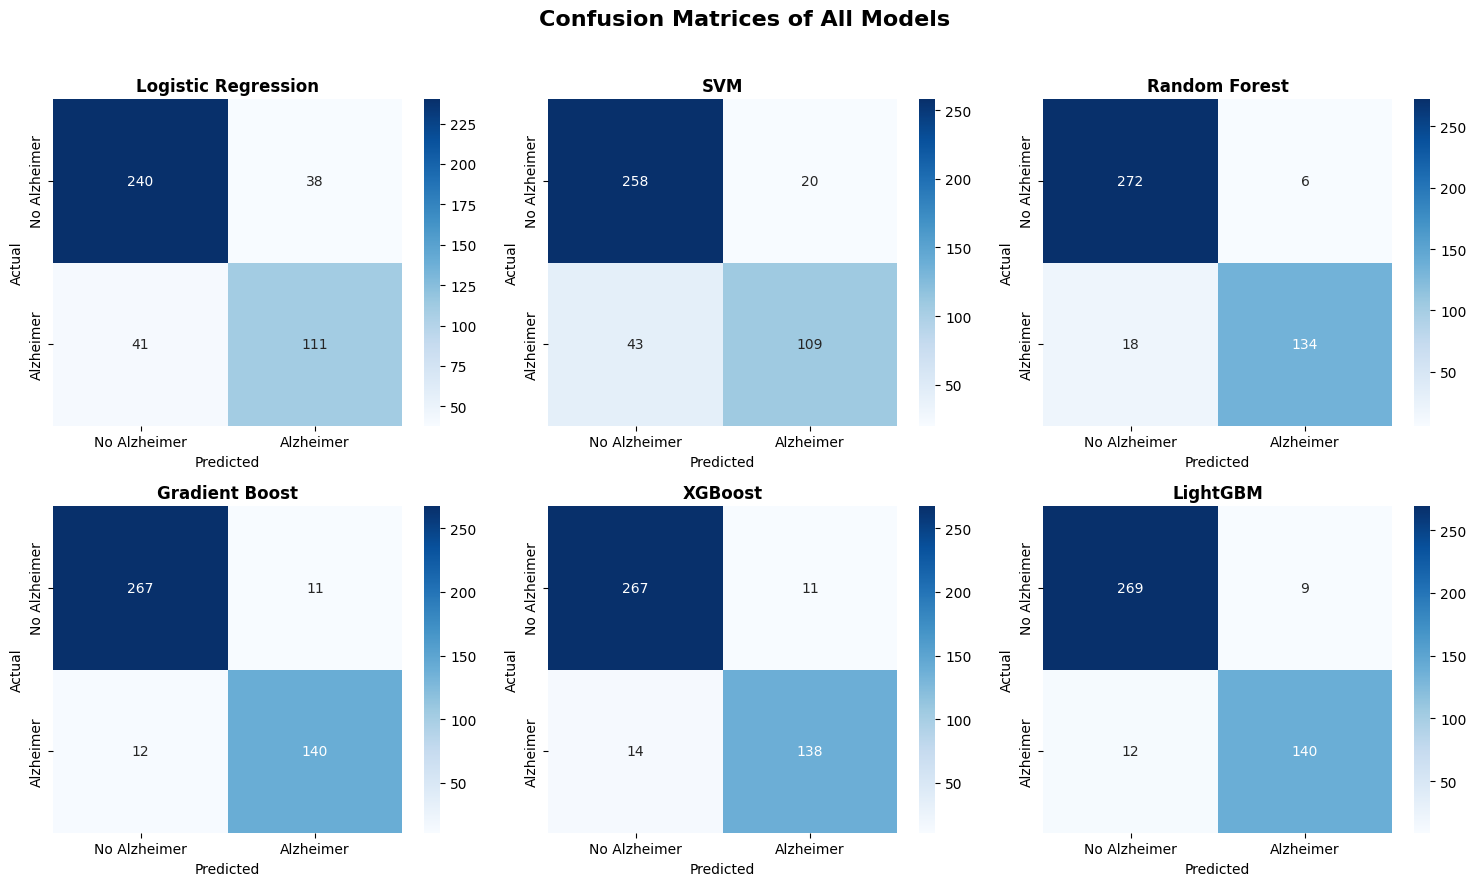

In [11]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.flatten() 

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Alzheimer", "Alzheimer"],
                yticklabels=["No Alzheimer", "Alzheimer"],
                ax=ax)

    ax.set_title(f"{name}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.suptitle("Confusion Matrices of All Models", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**ROC Curves for All Models**

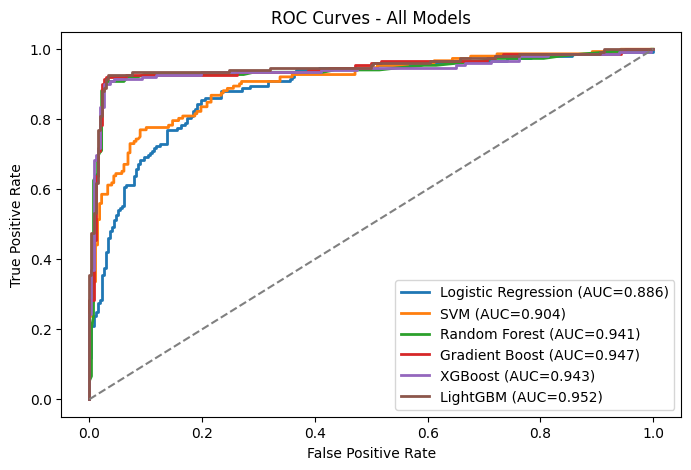

In [12]:
# Plot ROC curves for all models
plt.figure(figsize=(8,5))

for name, model in models.items():
    try:
        y_prob = model.predict_proba(X_test)[:,1]
    except:
        y_prob = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'--', color="gray")
plt.title("ROC Curves - All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


**Feature importances**

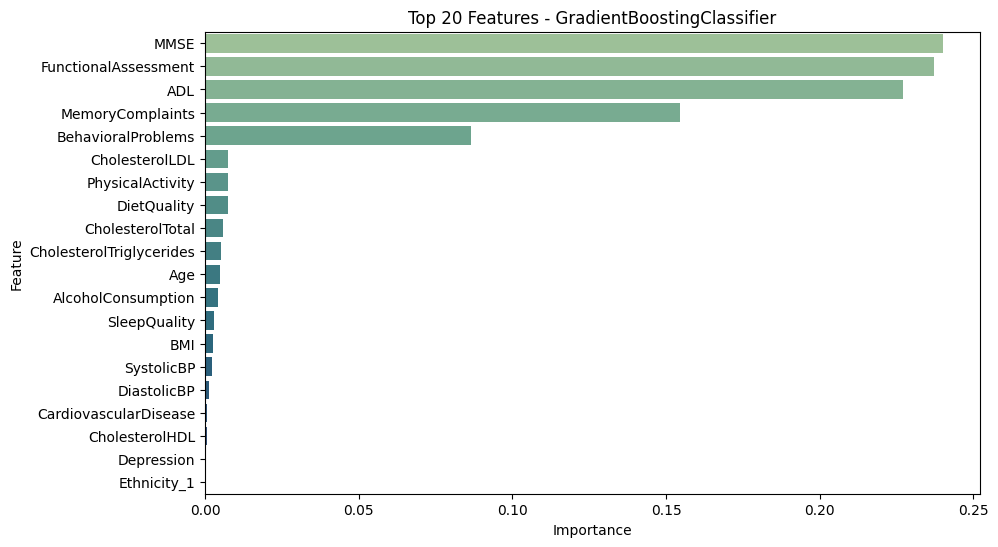

SVC does not support feature importances.
LogisticRegression does not support feature importances.


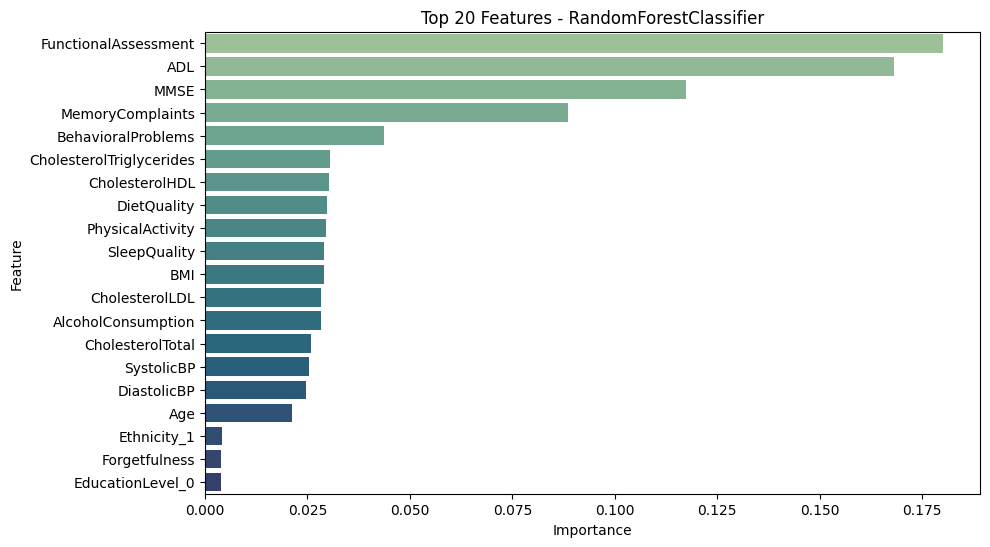

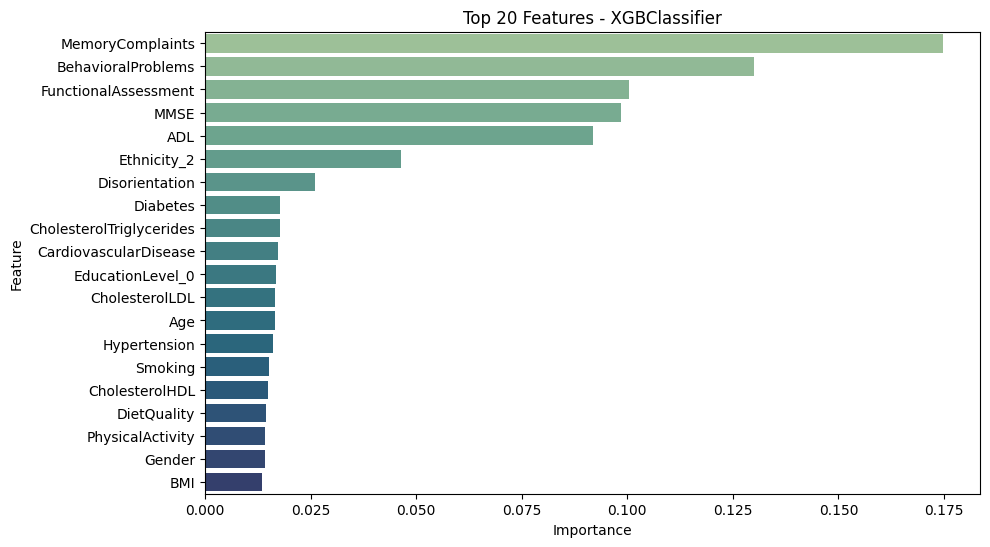

[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3290
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841


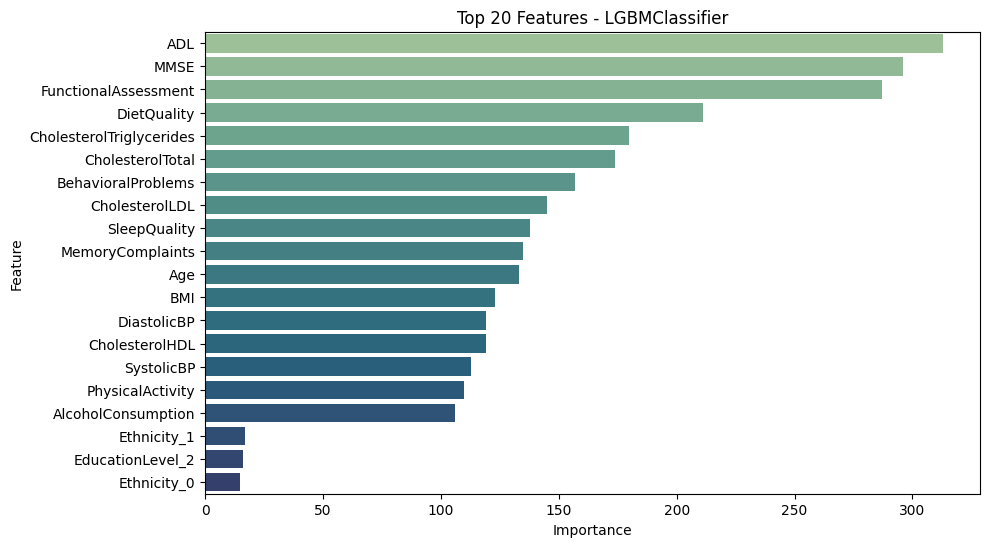

In [13]:
# Train models that support feature importances
models_with_feature_importances = [("GradientBoostingClassifier", GradientBoostingClassifier(n_estimators=100, random_state=42)),
                                   ("SVC", SVC(probability=True)),
                                   ("LogisticRegression", LogisticRegression(max_iter=2000)),
                                   ("RandomForestClassifier", RandomForestClassifier(n_estimators=100, random_state=42)),
                                   ("XGBClassifier", XGBClassifier(random_state=42)),
                                   ("LGBMClassifier", LGBMClassifier(random_state=42))]

# Iterate over models
for model_name, model in models_with_feature_importances:
    
    # Train model
    model.fit(X_train, y_train)
    
    # Get importance of features
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    else:
        # If the model does not have feature_importances_, continue to the next model
        print(f"{model_name} does not support feature importances.")
        continue

    # Create DataFrame for easier viewing
    feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 
                                           'Importance': feature_importances})
    
    # Sort by importance
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df[:20], palette='crest')
    plt.title(f"Top 20 Features - {model_name}")
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(False)
    plt.show()


**Model evaluation**

In [14]:
for i, (name, model) in enumerate(models.items(), start=1): 
    # re-fit to ensure clean state
    model.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    print()
    
    print(f"Model {i}: {name}")  
    print()
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    #classification report
    report = classification_report(y_test, model.predict(X_test))
    print()
    print("Classification Report:")
    print()
    print(report)
    print()
    
    print("-"*50)



Model 1: Logistic Regression

Training Accuracy: 0.8528214077952297
Testing Accuracy: 0.8162790697674419

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       278
           1       0.74      0.73      0.74       152

    accuracy                           0.82       430
   macro avg       0.80      0.80      0.80       430
weighted avg       0.82      0.82      0.82       430


--------------------------------------------------

Model 2: SVM

Training Accuracy: 0.9307737056428156
Testing Accuracy: 0.8534883720930233

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       278
           1       0.84      0.72      0.78       152

    accuracy                           0.85       430
   macro avg       0.85      0.82      0.83       430
weighted avg       0.85      0.85      0.85       430


-----------------------------------------------

**Summary Table of Metrics**

In [15]:
summary = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    summary.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1 Score": report["weighted avg"]["f1-score"]
    })

df_summary = pd.DataFrame(summary).sort_values("Accuracy", ascending=False)
df_summary


,Model,Accuracy,Precision,Recall,F1 Score
5,LightGBM,0.951163,0.951039,0.951163,0.951050
3,Gradient Boost,0.946512,0.946442,0.946512,0.946471
2,Random Forest,0.944186,0.944722,0.944186,0.943629
4,XGBoost,0.941860,0.941693,0.941860,0.941727
1,SVM,0.853488,0.852837,0.853488,0.850402
0,Logistic Regression,0.816279,0.815518,0.816279,0.815857


**Model Comparison**

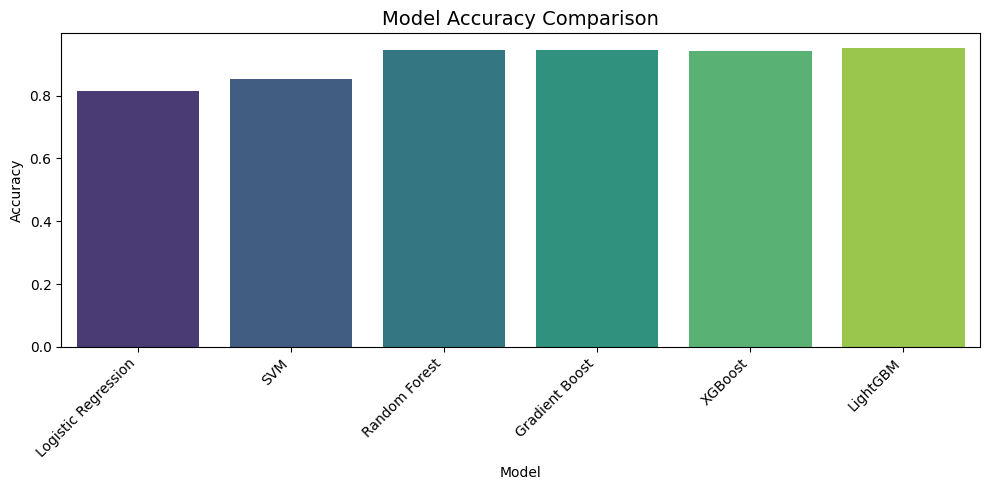

In [16]:
comparison_results = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall    = recall_score(y_test, y_pred, zero_division=0)
    f1        = f1_score(y_test, y_pred, zero_division=0)

    comparison_results.append([name, accuracy, precision, recall, f1])

comparison_df = pd.DataFrame(
    comparison_results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"]
)

comparison_df.style.background_gradient(cmap="YlGnBu")

plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="Accuracy", data=comparison_df, palette="viridis")
plt.title("Model Accuracy Comparison", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


**Cross-Validation**

In [17]:
cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[name] = {
        "Mean CV Score": scores.mean(),
        "Std CV Score": scores.std()
    }

cv_df = pd.DataFrame(cv_results).T
cv_df

[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3290
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841
[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3290
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM]

,Mean CV Score,Std CV Score
Logistic Regression,0.834757,0.055456
SVM,0.837552,0.052060
Random Forest,0.936189,0.065205
Gradient Boost,0.945960,0.066465
XGBoost,0.946426,0.065635
LightGBM,0.949218,0.065541


**Visualize Model Performance**

In [18]:
accuracy_list  = []
precision_list = []
recall_list    = []
f1_list        = []
model_names    = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    model_names.append(name)
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred, zero_division=0))
    recall_list.append(recall_score(y_test, y_pred, zero_division=0))
    f1_list.append(f1_score(y_test, y_pred, zero_division=0))


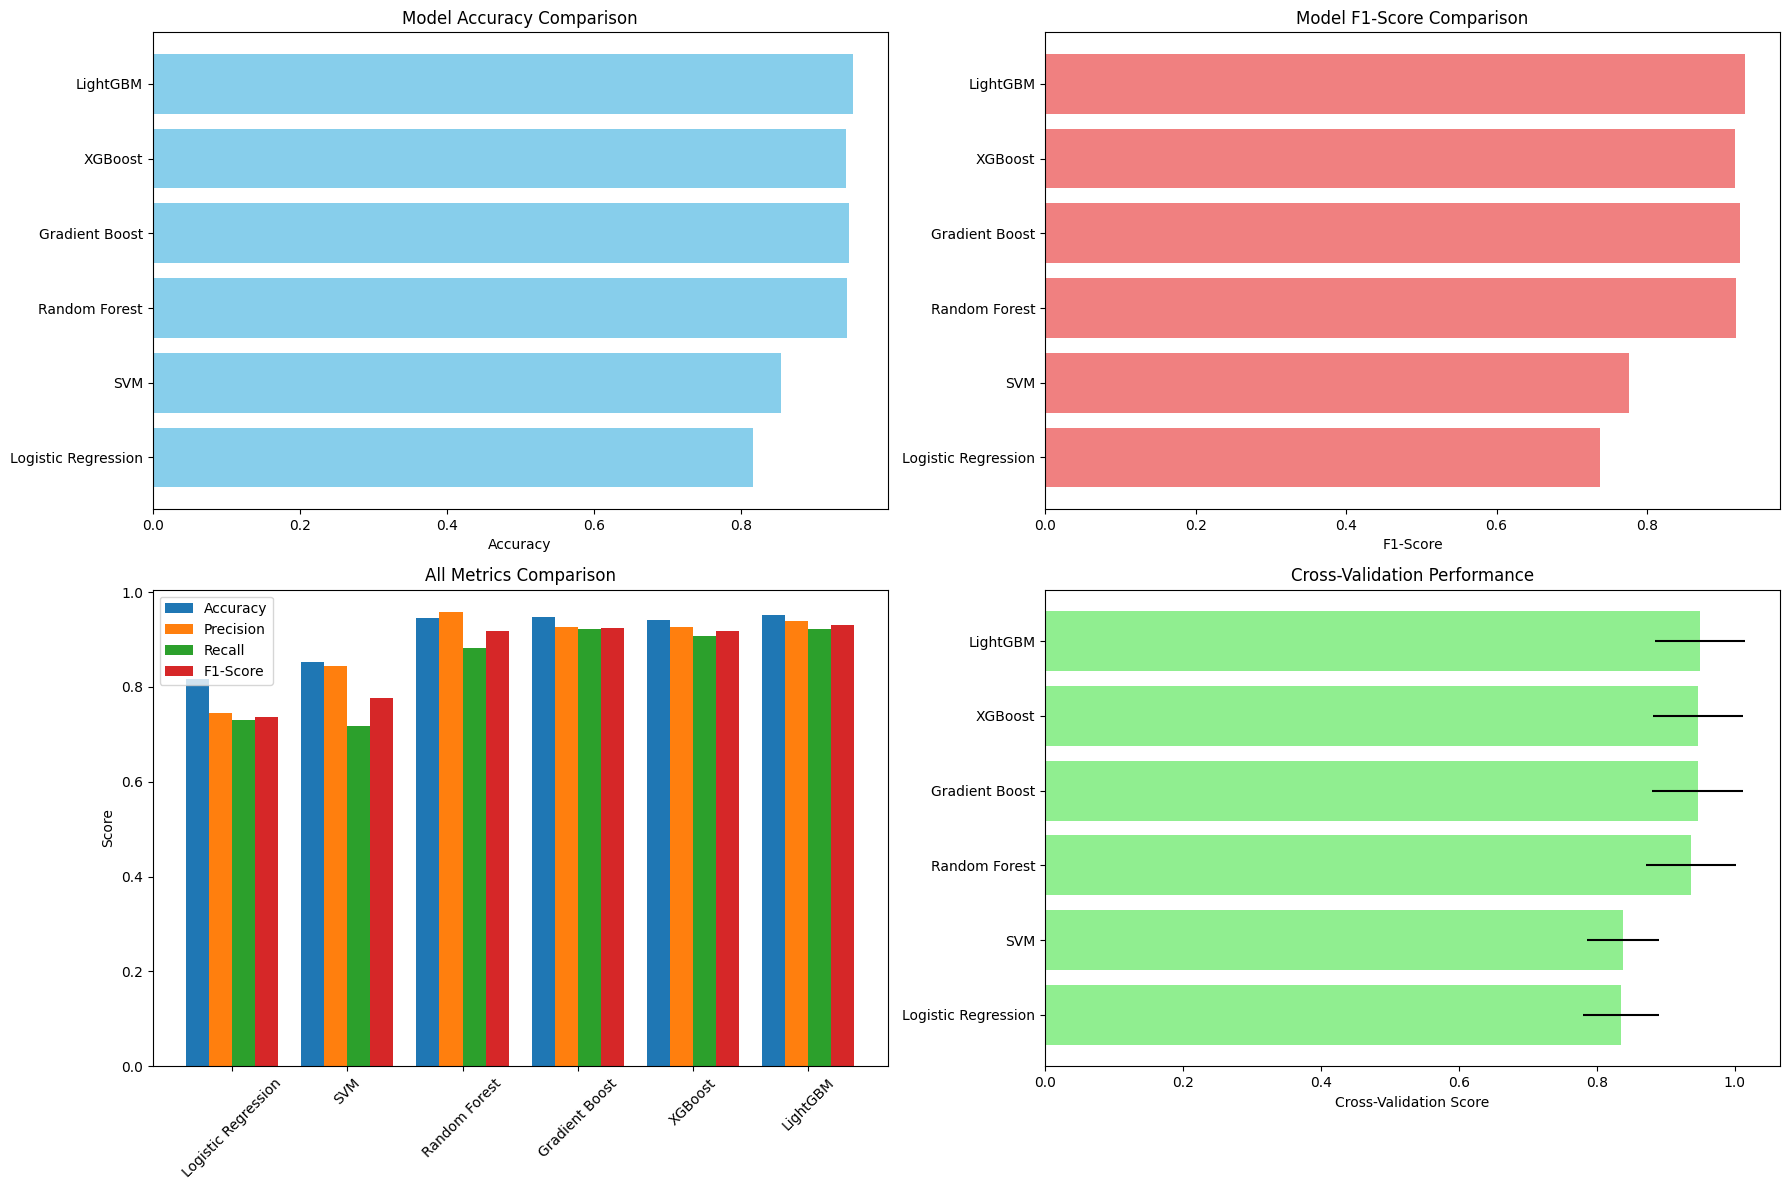

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

#accuracy comparison
axes[0,0].barh(model_names, accuracy_list, color="skyblue")
axes[0,0].set_title("Model Accuracy Comparison")
axes[0,0].set_xlabel("Accuracy")

# F1 Score Comparison
axes[0,1].barh(model_names, f1_list, color="lightcoral")
axes[0,1].set_title("Model F1-Score Comparison")
axes[0,1].set_xlabel("F1-Score")

# All Metrics Comparison
x = np.arange(len(model_names))
width = 0.2

axes[1,0].bar(x - width*1.5, accuracy_list,  width, label="Accuracy")
axes[1,0].bar(x - width*0.5, precision_list, width, label="Precision")
axes[1,0].bar(x + width*0.5, recall_list,    width, label="Recall")
axes[1,0].bar(x + width*1.5, f1_list,        width, label="F1-Score")

axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(model_names, rotation=45)
axes[1,0].set_title("All Metrics Comparison")
axes[1,0].set_ylabel("Score")
axes[1,0].legend()

# Cross-Validation Performance
cv_means = [cv_df.loc[name]["Mean CV Score"] for name in model_names]
cv_stds  = [cv_df.loc[name]["Std CV Score"] for name in model_names]

axes[1,1].barh(model_names, cv_means, xerr=cv_stds, color="lightgreen")
axes[1,1].set_title("Cross-Validation Performance")
axes[1,1].set_xlabel("Cross-Validation Score")

plt.tight_layout()
plt.show()


**Best Model Selection**


Selecting the best model based on Test Accuracy...

BEST MODEL SELECTED: LightGBM
[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3290
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841

FINAL CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       278
           1       0.94      0.92      0.93       152

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.95       430
weighted avg       0.95      0.95      0.95       430



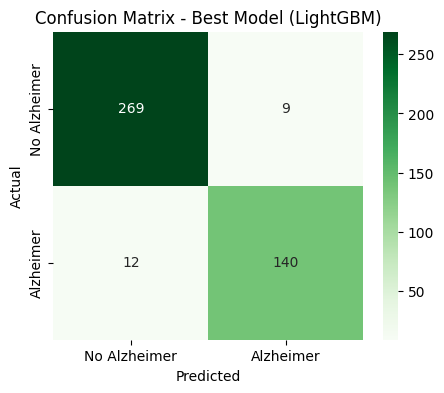


Model saved as best_model.pkl


In [20]:
print("\nSelecting the best model based on Test Accuracy...\n")

# Get best model name
best_model_name = df_summary.iloc[0]['Model']
best_model = models[best_model_name]

print(f"{'='*80}")
print(f"BEST MODEL SELECTED: {best_model_name}")
print(f"{'='*80}")

# Retrain best model on entire training data
best_model.fit(X_train, y_train)

# Final predictions
y_pred_final = best_model.predict(X_test)

# Final detailed report
print("\nFINAL CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_final))

# Confusion Matrix of best model
plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=["No Alzheimer", "Alzheimer"],
            yticklabels=["No Alzheimer", "Alzheimer"])
plt.title(f"Confusion Matrix - Best Model ({best_model_name})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save best model
import joblib
joblib.dump(best_model, "best_model.pkl")

print("\nModel saved as best_model.pkl")
